In [1]:
import matplotlib.pyplot as plt
import proplot as pplt
import fitsio
import numpy as np
import meds
import glob

from des_y6utils.viz import get_ngmix_meds_reader

In [2]:
def _comp_mags(flux, i):
    zp = 30.0
    b_array = np.array([3.27e-12, 4.83e-12, 6.0e-12, 9.0e-12])
    bscale = np.array(b_array) * 10.**(zp / 2.5)
    mag = 2.5 * np.log10(1.0 / b_array[i]) - np.arcsinh(0.5 * flux / bscale[i]) / (0.4 * np.log(10.0))
    # mag_err = 2.5 * fluxerr / (2.0 * bscale[i] * np.log(10.0) * np.sqrt(1.0 + (0.5 * flux / bscale[i])**2.))    
    return mag


# copied from Masa
def cut_cat(d, mdet_mom):
    mag_g = _comp_mags(d[mdet_mom + "_band_flux_g"], 0)
    mag_r = _comp_mags(d[mdet_mom + "_band_flux_r"], 1)
    mag_i = _comp_mags(d[mdet_mom + "_band_flux_i"], 2)
    mag_z = _comp_mags(d[mdet_mom + "_band_flux_z"], 3)
    gmr = mag_g - mag_r
    rmi = mag_r - mag_i
    imz = mag_i - mag_z

    msk = (
        (d[mdet_mom + "_flags"] == 0) & 
        (d["mask_flags"] == 0) & 
        (d["shear_bands"] == '0123') & 
        (d[mdet_mom+"_band_flux_flags_g"] == 0) & 
        (d[mdet_mom+"_band_flux_flags_r"] == 0) & 
        (d[mdet_mom+"_band_flux_flags_i"] == 0) & 
        (d[mdet_mom+"_band_flux_flags_z"] == 0) & 
        (d[mdet_mom+"_s2n"] > 10) & 
        (d["mfrac"] < 0.1) &
        (np.abs(gmr) < 5) & 
        (np.abs(rmi) < 5) & 
        (np.abs(imz) < 5) & 
        np.isfinite(mag_g) & 
        np.isfinite(mag_r) &
        np.isfinite(mag_i) & 
        np.isfinite(mag_z) & 
        (mag_g < 26.5) & 
        (mag_r < 26.5) & 
        (mag_i < 26.2) & 
        (mag_z < 25.6))
    
    if mdet_mom == 'wmom':
        msk_add = ((d[mdet_mom + "_T_ratio"] > 1.2))
        msk = msk & msk_add
    elif mdet_mom == 'pgauss':
        msk_add = ((d[mdet_mom + "_T_ratio"] > 0.5) & (d[mdet_mom + "_T"] < 1.9 - 2.8*d[mdet_mom + "_T_err"]))
        msk = msk & msk_add
    elif mdet_mom == 'pgauss_reg0.90':
        msk_add = ((d[mdet_mom + "_T_ratio"] > 0.5) & (d[mdet_mom + "_T"] < 1.9 - 2.8*d[mdet_mom + "_T_err"]))
        msk = msk & msk_add
        
    return d[msk]

In [3]:
dt = fitsio.read("../2022_08_24_blind_and_test_final_cats/fnames.fits")
tnames = set([t for t in dt["TILENAME"]])
mdet_mom = "pgauss"

In [23]:
import glob
import tqdm

for tname in tqdm.tqdm(tnames):
    d = fitsio.read(glob.glob("../2022_08_24_blind_and_test_final_cats/blinded_data/*%s*.fits" % tname)[0])

    d = cut_cat(d, "pgauss")

    g2 = d[mdet_mom + "_g_1"]**2 + d[mdet_mom + "_g_2"]**2
    g2max = g2[(d["mdet_step"] == "noshear")].max()
    gvar = d[mdet_mom + "_g_cov_1_1"] + d[mdet_mom + "_g_cov_2_2"]
    pg1min = d[(d["mdet_step"] == "noshear")]["psfrec_g_1"].min()
    
    msk_dns = (d["psfrec_g_1"] < -0.07) & (g2 > 7) & (d["mdet_step"] == "noshear")
    if msk_dns.sum() > 0:
        print(tname, g2max, pg1min)

  0%|          | 10/5448 [00:22<3:31:17,  2.33s/it]

DES0137-6248 10.426633884093702 -0.11006379535982594


  0%|          | 18/5448 [00:42<3:32:55,  2.35s/it]


KeyboardInterrupt: 

In [6]:
def _load_tile(tilename):
    d = fitsio.read(glob.glob("../2022_08_24_blind_and_test_final_cats/blinded_data/*%s*.fits" % tilename)[0])

    d = cut_cat(d, "pgauss")

    g2 = d[mdet_mom + "_g_1"]**2 + d[mdet_mom + "_g_2"]**2

    g1_frac_err = np.sqrt(d[mdet_mom + "_g_cov_1_1"])/np.abs(d[mdet_mom + "_g_1"])
    g2_frac_err = np.sqrt(d[mdet_mom + "_g_cov_2_2"])/np.abs(d[mdet_mom + "_g_2"])

    g12_frac_err = g1_frac_err * np.sqrt(2)
    g22_frac_err = g2_frac_err * np.sqrt(2)

    g12_err = g12_frac_err * (d[mdet_mom + "_g_1"])**2
    g22_err = g22_frac_err * (d[mdet_mom + "_g_2"])**2

    g2_err = g12_err + g22_err

    g2_s2n = g2 / g2_err

    sb = (
        d[mdet_mom + "_band_flux_g"]
        + d[mdet_mom + "_band_flux_r"]
        + d[mdet_mom + "_band_flux_i"]
        + d[mdet_mom + "_band_flux_z"]
    )/d[mdet_mom + "_T"]
    
    return d, g2, g2_err, sb

### To Do

 - ~Plot object images for very negative psfrec_g1 and large shears~
 - Plot objects w/ low S/N and large shears
 - Plot coadds for very negative psfrec_g1 (done, maybe edge CCDs?)
 - Plot objects from tails of T, S/N, g, etc


### very negative psfrec_g1 and large shears

In [7]:
d, g2, g2_err, sb = _load_tile("DES0137-6248")

msk = (
    (d["mdet_step"] == "noshear")
    & (g2 > 5)
    & (d["psfrec_g_1"] < -0.05)
)

pvals = [
    (d[msk][i]["slice_id"],
     d[msk][i]["slice_x"],
     d[msk][i]["slice_y"],
    )
    for i in range(msk.sum())
]

print(msk.sum())

5


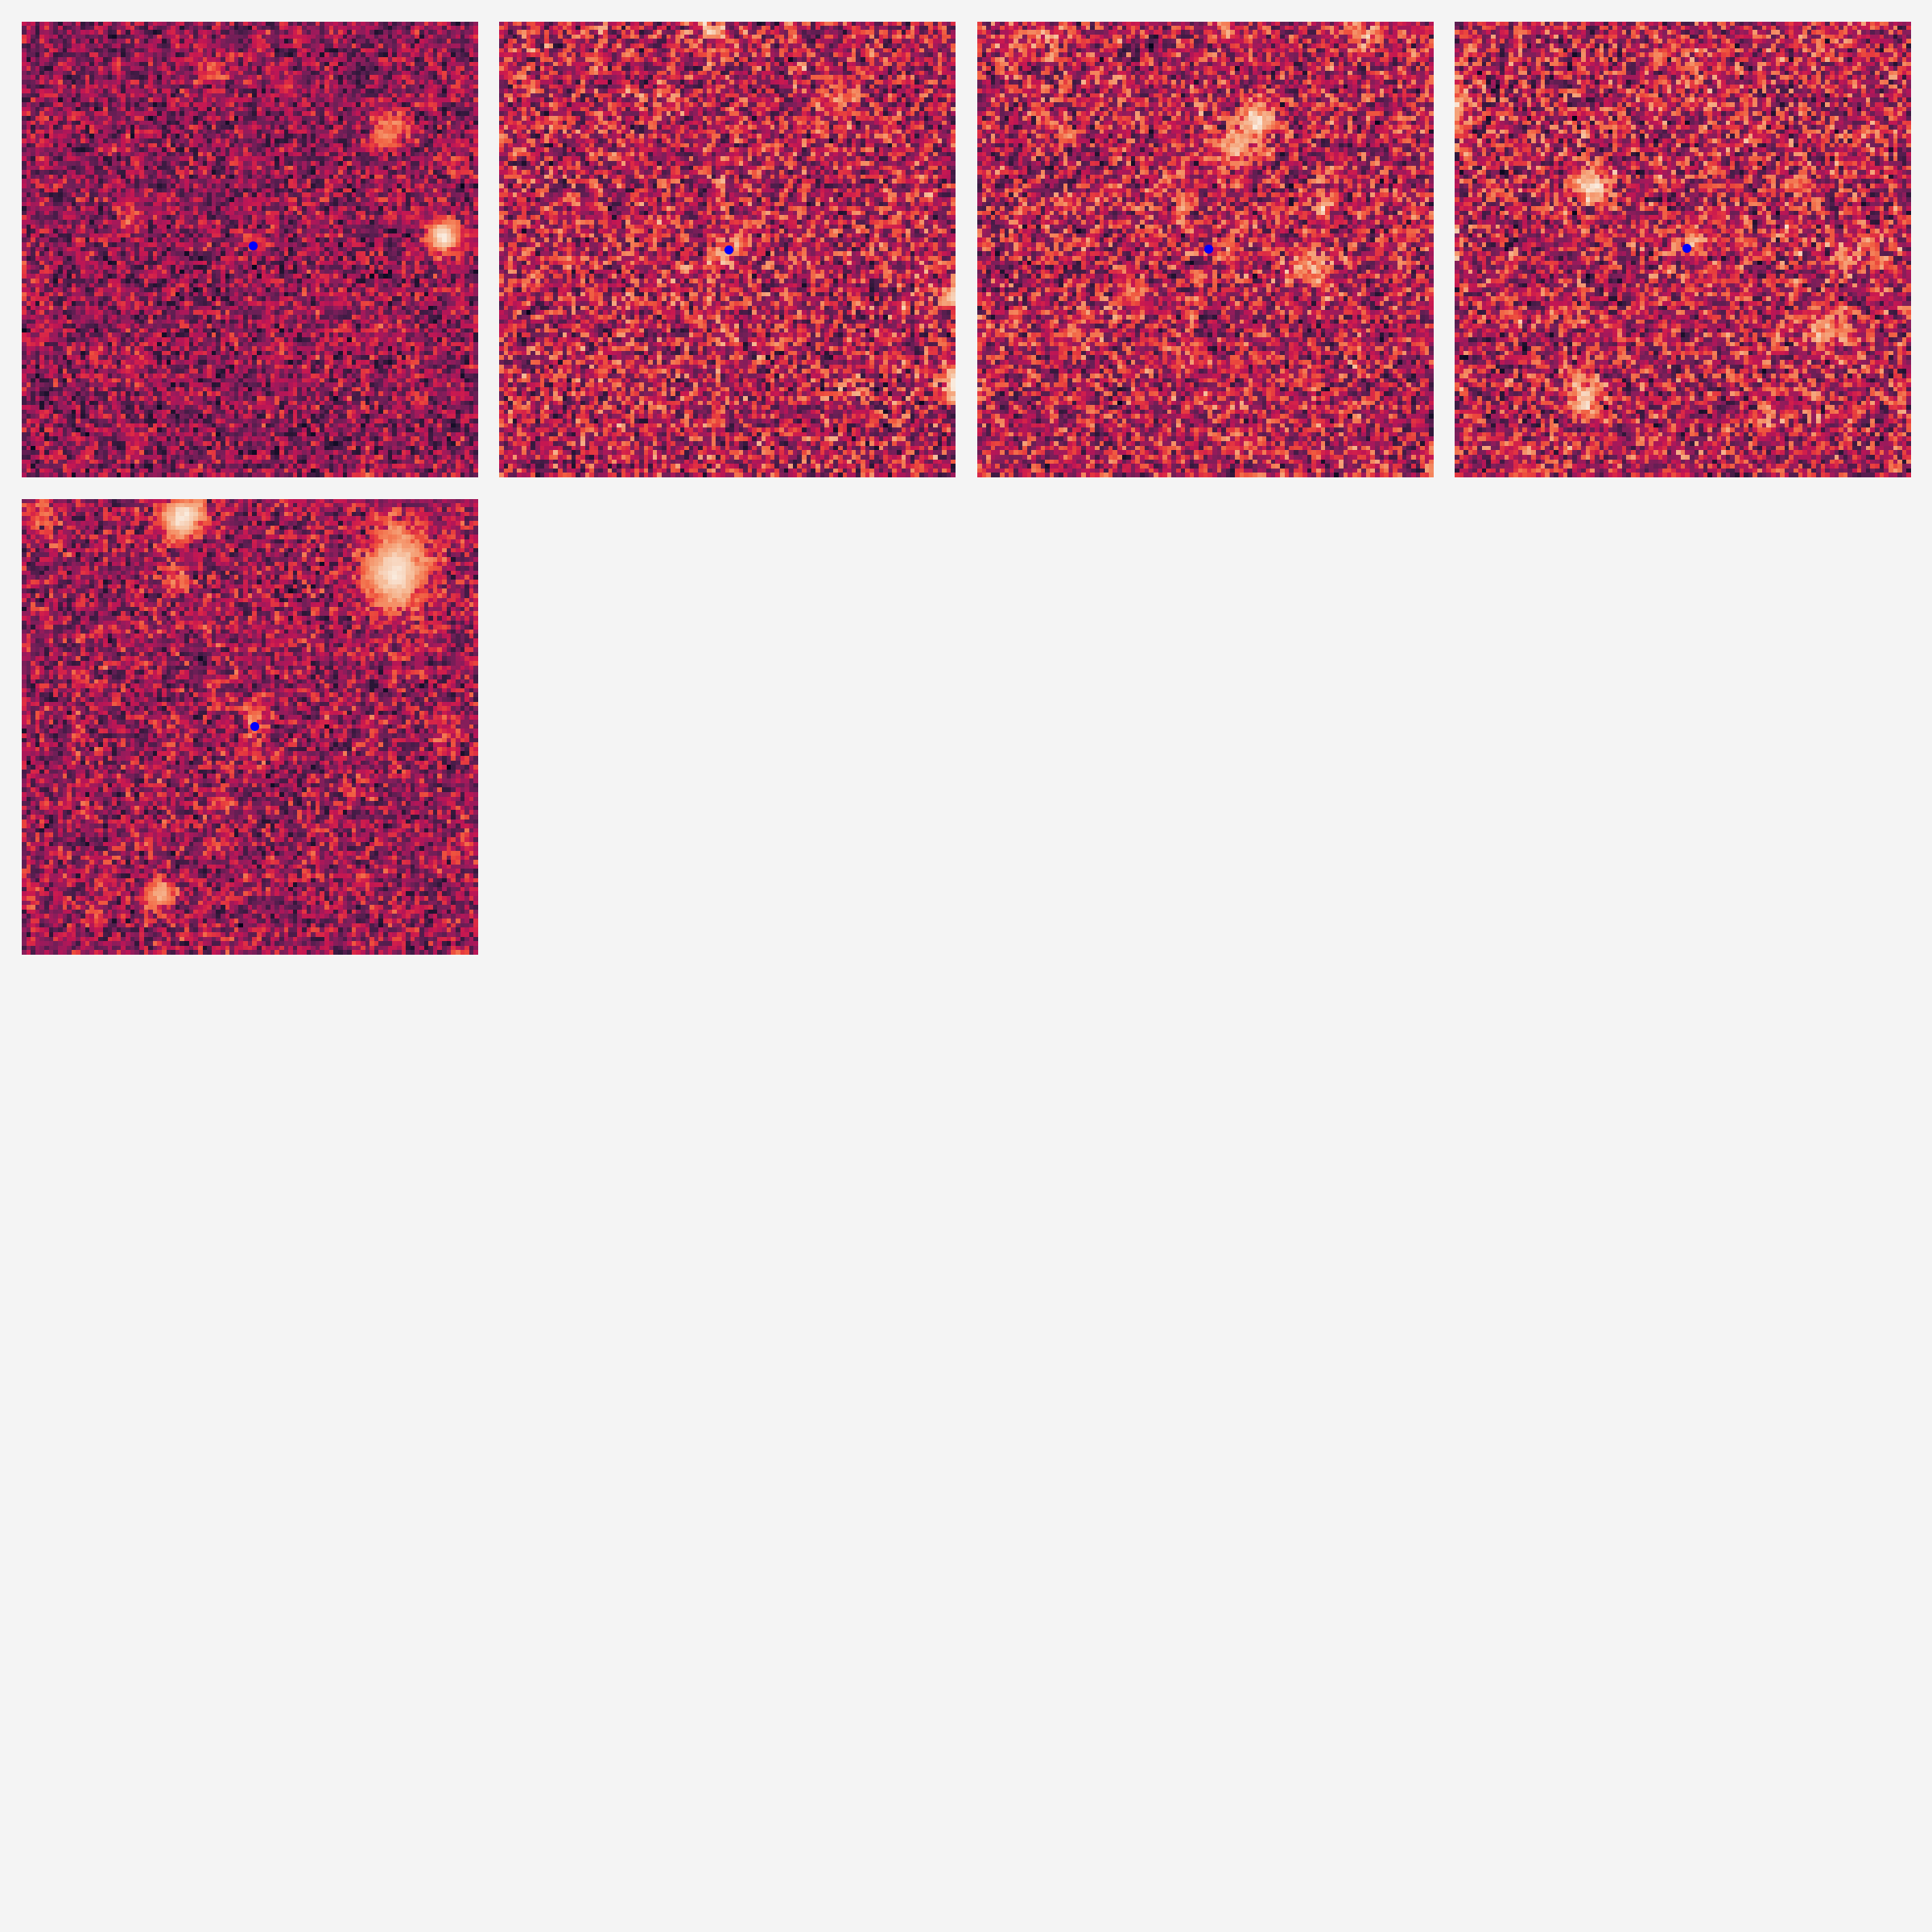

In [9]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
bind = 0

axs = axs.ravel()

for i in range(msk.sum()):
    slice_id = pvals[i][0]
    slice_x = pvals[i][1]
    slice_y = pvals[i][2]

    box_size = 101
    
    if i == 16:
        break
        
    ax = axs[i]

    with get_ngmix_meds_reader(tilename) as mbmeds:
        mbobs = mbmeds.get_mbobs(slice_id)

        im = mbobs[bind][0].image
        wgt = mbobs[bind][0].weight

        ax.imshow(
            np.arcsinh(im * np.sqrt(wgt))[
                int(slice_y + 0.5 - box_size/2):int(slice_y + 0.5 + box_size/2), 
                int(slice_x + 0.5 - box_size/2):int(slice_x + 0.5 + box_size/2)
            ],  
            cmap="rocket",
            origin="lower"

        )
        ax.grid(False)
        ax.axis("off")
        ax.plot(
            slice_x - int(slice_x + 0.5 - box_size/2), 
            slice_y - int(slice_y + 0.5 - box_size/2), 
            ".b",
        )

#     for name in d.dtype.names:
#         print("%s: %r" % (name, d[msk][i][name]))
#     print("sb: %r" % sb[msk][i])
#     print(" ")
    
    
if msk.sum() < 16:
    for j in range(msk.sum(), 16):
        axs[j].axis("off")
        
fig.tight_layout()

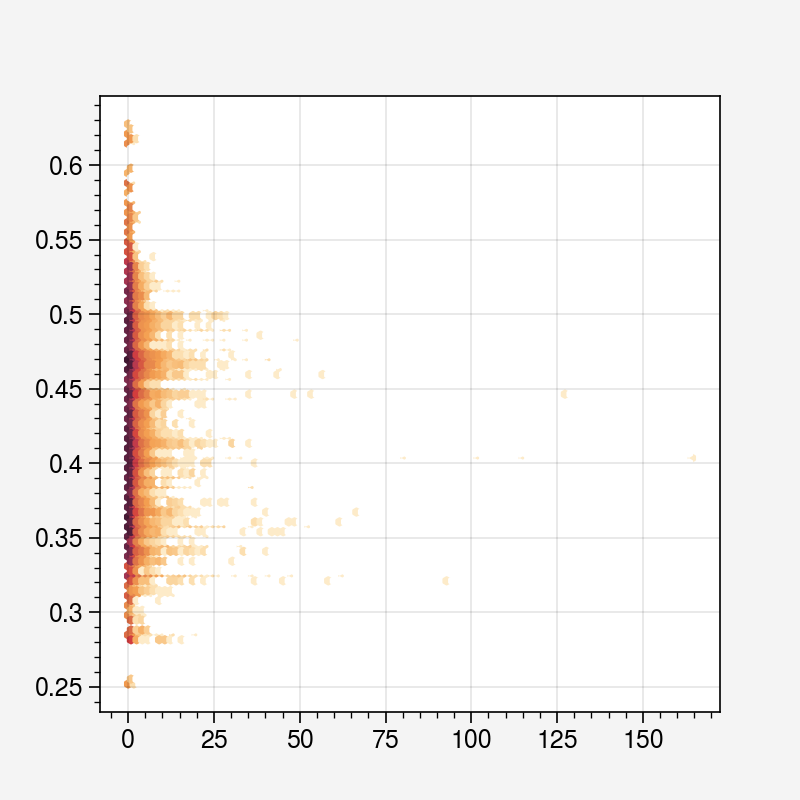

In [220]:
plt.hexbin(
    g2, d["psfrec_T"], bins="log",
)

### Check the Cell Coadd

In [223]:
msk = (
    (d["mdet_step"] == "noshear")
    & (g2 > 50)
)

slice_ids = sorted(set([
    d[msk][i]["slice_id"]
    for i in range(msk.sum())
]))
print(slice_ids)

[5355, 6479]


slice_id: 5355
mdet_step: 'noshear'
ra: 3.8760224837271653
dec: -39.210184287263495
ra_noshear: 3.8760224837271653
dec_noshear: -39.210184287263495
y_noshear: 5498.0283203125
x_noshear: 968.4860229492188
y: 5498.0283203125
x: 968.4860229492188
slice_y: 98.02830505371094
slice_x: 68.48603820800781
slice_y_noshear: 98.02830505371094
slice_x_noshear: 68.48603820800781
hpix_16384: 2327362665
hpix_16384_noshear: 2327362665
filename: 'DES0013-3914_r5935p01_metadetect.fits'
tilename: 'DES0013-3914'
mask_flags: 0
mask_flags_noshear: 0
nepoch_g: 6
nepoch_r: 6
nepoch_i: 5
nepoch_z: 7
nepoch_eff_g: 4
nepoch_eff_r: 5
nepoch_eff_i: 2
nepoch_eff_z: 5
wmom_flags: 0
wmom_psf_flags: 0
wmom_psf_g_1: 1.4382270574444082e-06
wmom_psf_g_2: -3.001459805108951e-07
wmom_psf_T: 0.23501466278684982
wmom_obj_flags: 0
wmom_s2n: 20.709370629417755
wmom_g_1: -0.8875885117371519
wmom_g_2: -0.3502005824402038
wmom_g_cov_1_1: 0.008465333704339542
wmom_g_cov_1_2: 0.0
wmom_g_cov_2_2: 0.0038433807964120673
wmom_T: 0.22927

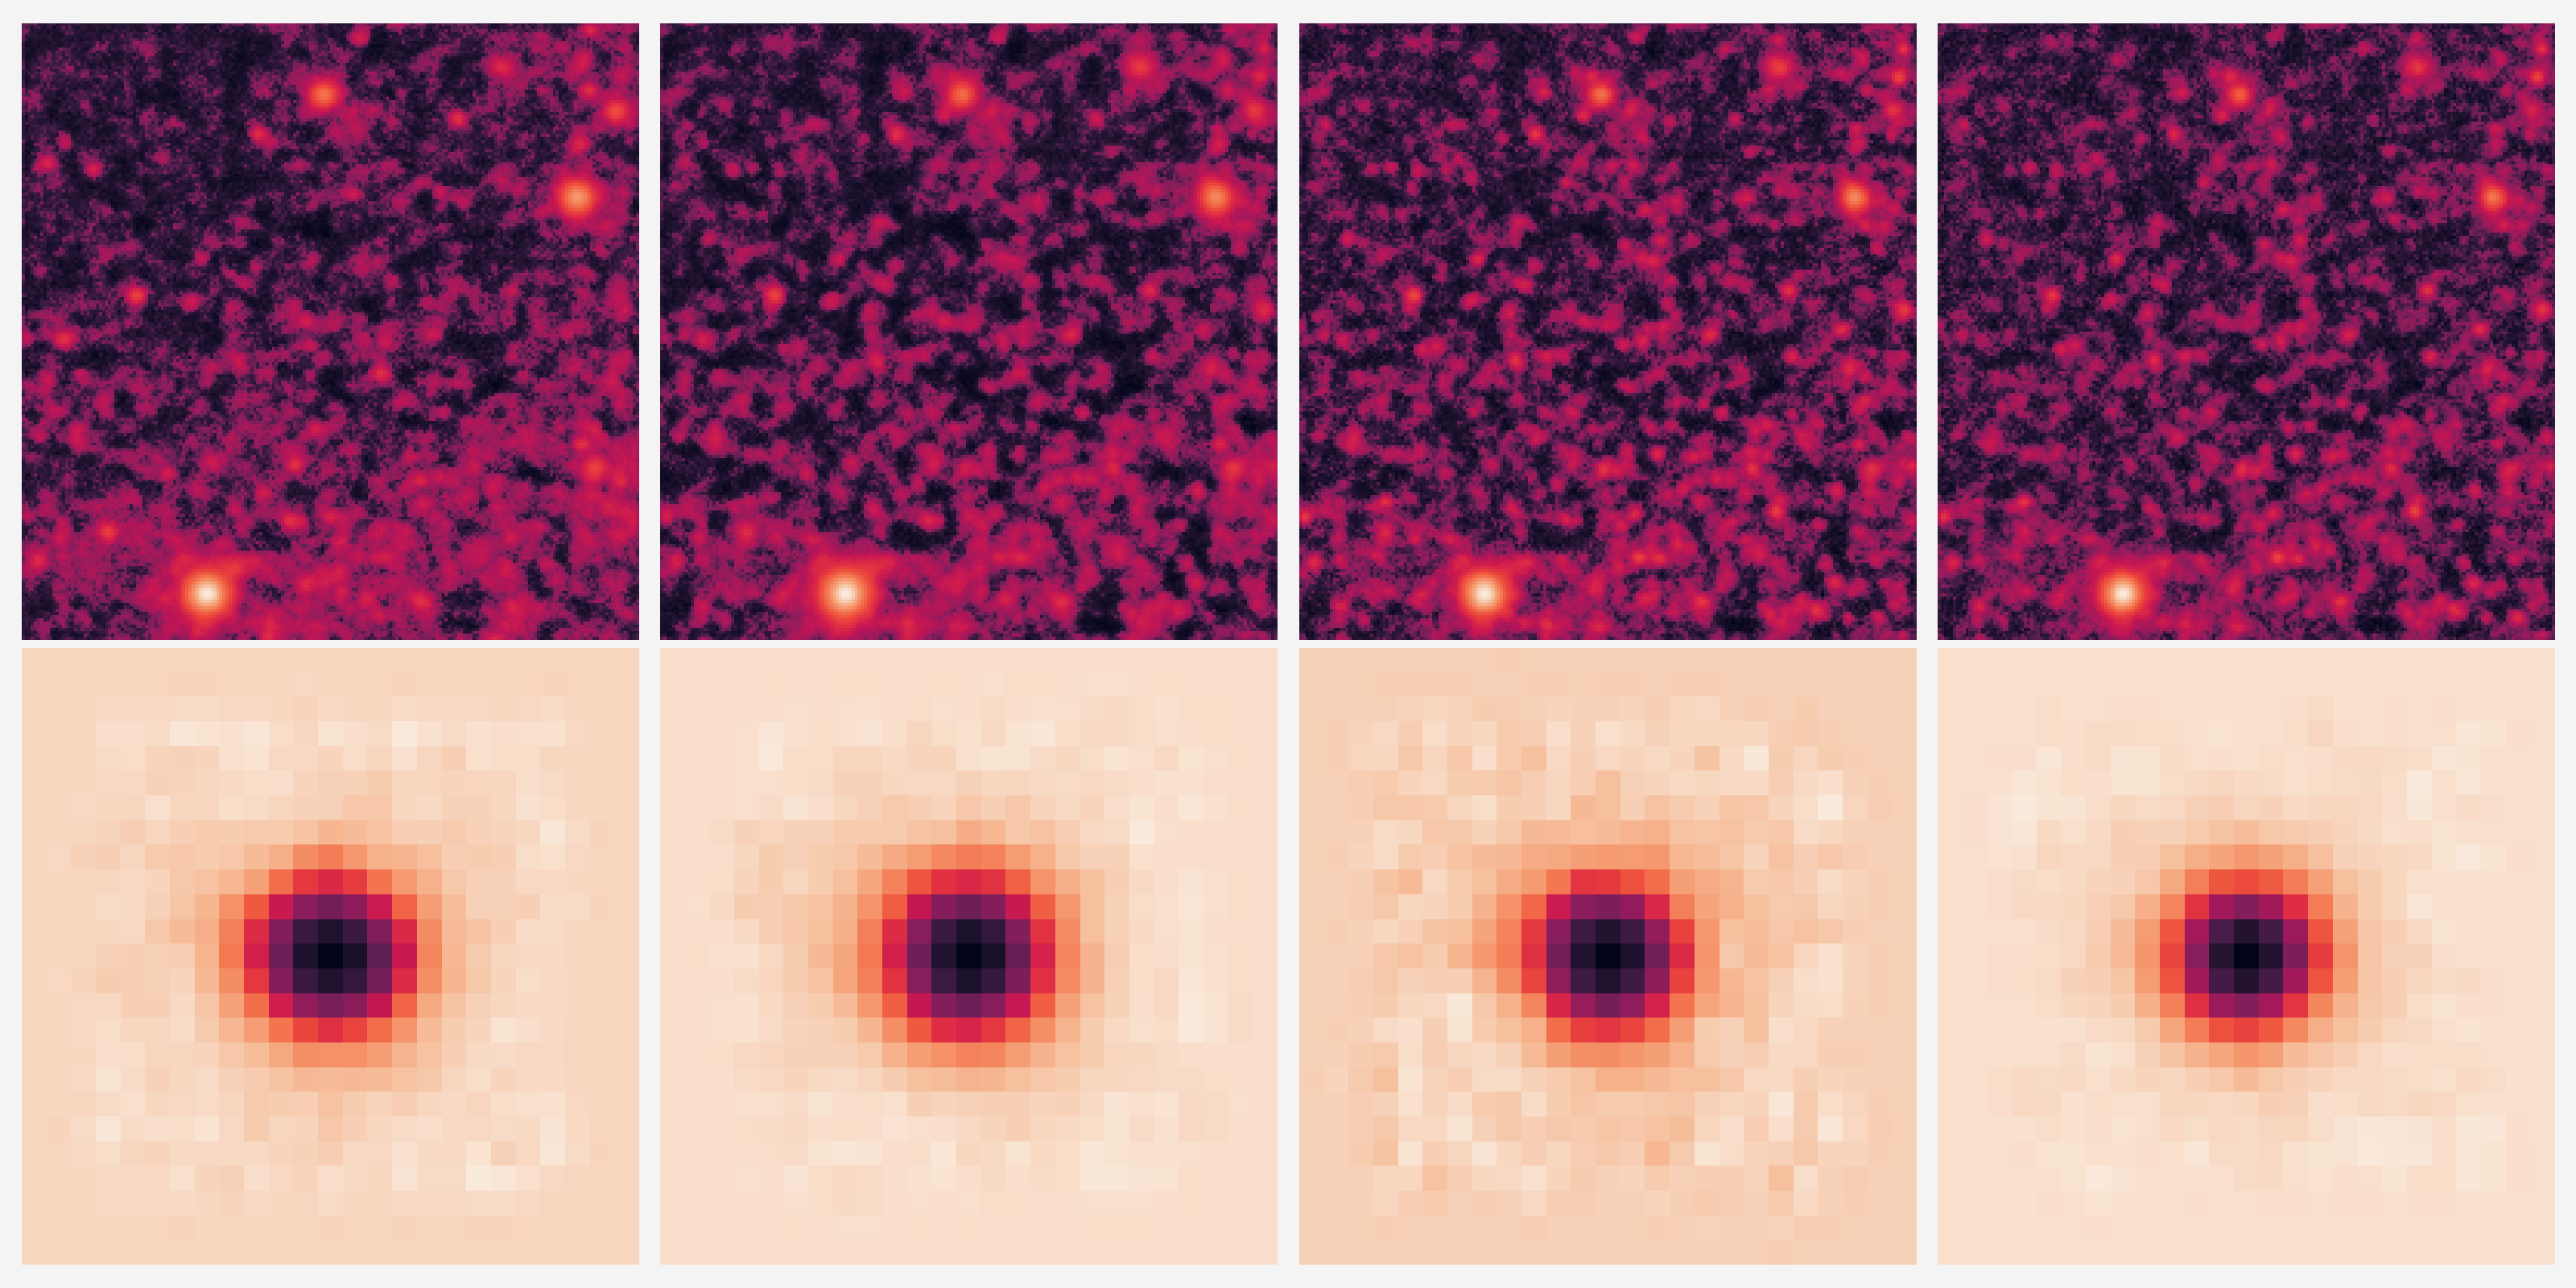

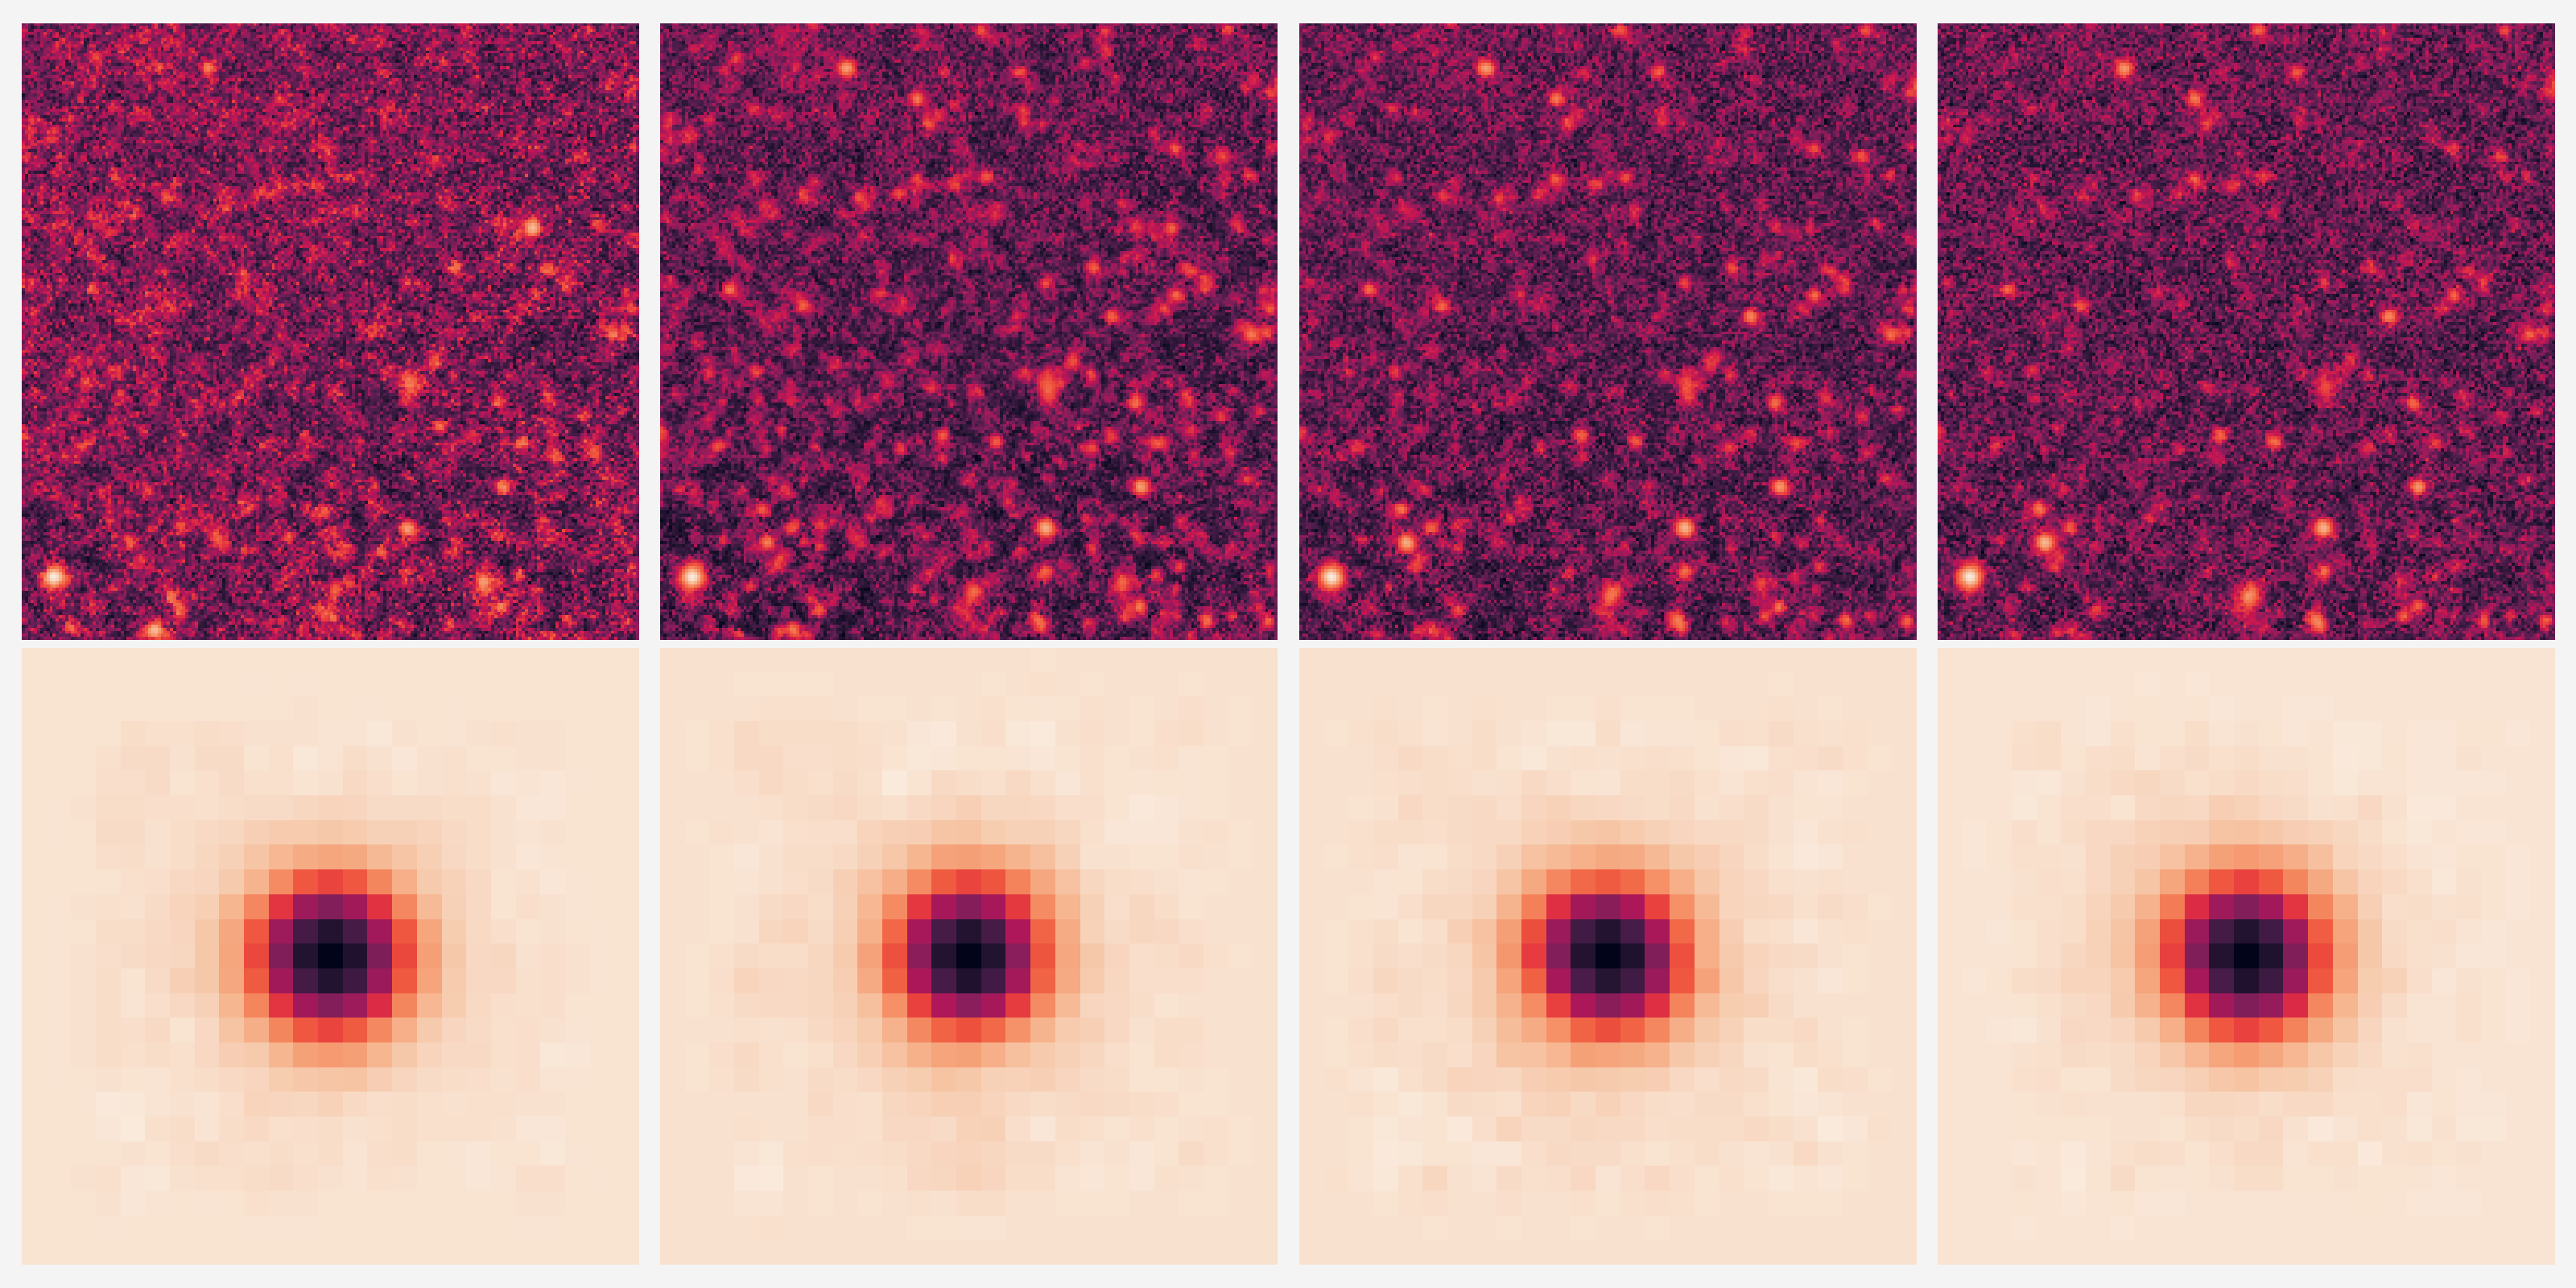

In [224]:
for slice_id in slice_ids:
    mbobs = mbmeds.get_mbobs(slice_id)

    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
    for bind in range(4):
        im = mbobs[bind][0].image
        wgt = mbobs[bind][0].weight

        axs[0, bind].imshow(
            np.arcsinh(im * np.sqrt(wgt)),  
            cmap="rocket",
            origin="lower"
        )
        axs[0, bind].grid(False)
        axs[0, bind].axis("off")

        psf = mbobs[bind][0].psf.image
        axs[1, bind].imshow(
            np.arcsinh(psf[13:-13, 13:-13]/7e-3),  
            cmap="rocket_r",
            origin="lower"
        )
        axs[1, bind].grid(False)
        axs[1, bind].axis("off")

    fig.tight_layout()
    
for i in range(msk.sum()):
    for col in d.dtype.names:
        print("%s: %r" % (col, d[msk][col][i]))

### Look at Objects

In [225]:
msk = (
    (d["mdet_step"] == "noshear")
    & (g2 > 50)
)

pvals = [
    (d[msk][i]["slice_id"],
     d[msk][i]["slice_x"],
     d[msk][i]["slice_y"],
    )
    for i in range(msk.sum())
]

slice_id: 5355
mdet_step: 'noshear'
ra: 3.8760224837271653
dec: -39.210184287263495
ra_noshear: 3.8760224837271653
dec_noshear: -39.210184287263495
y_noshear: 5498.0283203125
x_noshear: 968.4860229492188
y: 5498.0283203125
x: 968.4860229492188
slice_y: 98.02830505371094
slice_x: 68.48603820800781
slice_y_noshear: 98.02830505371094
slice_x_noshear: 68.48603820800781
hpix_16384: 2327362665
hpix_16384_noshear: 2327362665
filename: 'DES0013-3914_r5935p01_metadetect.fits'
tilename: 'DES0013-3914'
mask_flags: 0
mask_flags_noshear: 0
nepoch_g: 6
nepoch_r: 6
nepoch_i: 5
nepoch_z: 7
nepoch_eff_g: 4
nepoch_eff_r: 5
nepoch_eff_i: 2
nepoch_eff_z: 5
wmom_flags: 0
wmom_psf_flags: 0
wmom_psf_g_1: 1.4382270574444082e-06
wmom_psf_g_2: -3.001459805108951e-07
wmom_psf_T: 0.23501466278684982
wmom_obj_flags: 0
wmom_s2n: 20.709370629417755
wmom_g_1: -0.8875885117371519
wmom_g_2: -0.3502005824402038
wmom_g_cov_1_1: 0.008465333704339542
wmom_g_cov_1_2: 0.0
wmom_g_cov_2_2: 0.0038433807964120673
wmom_T: 0.22927

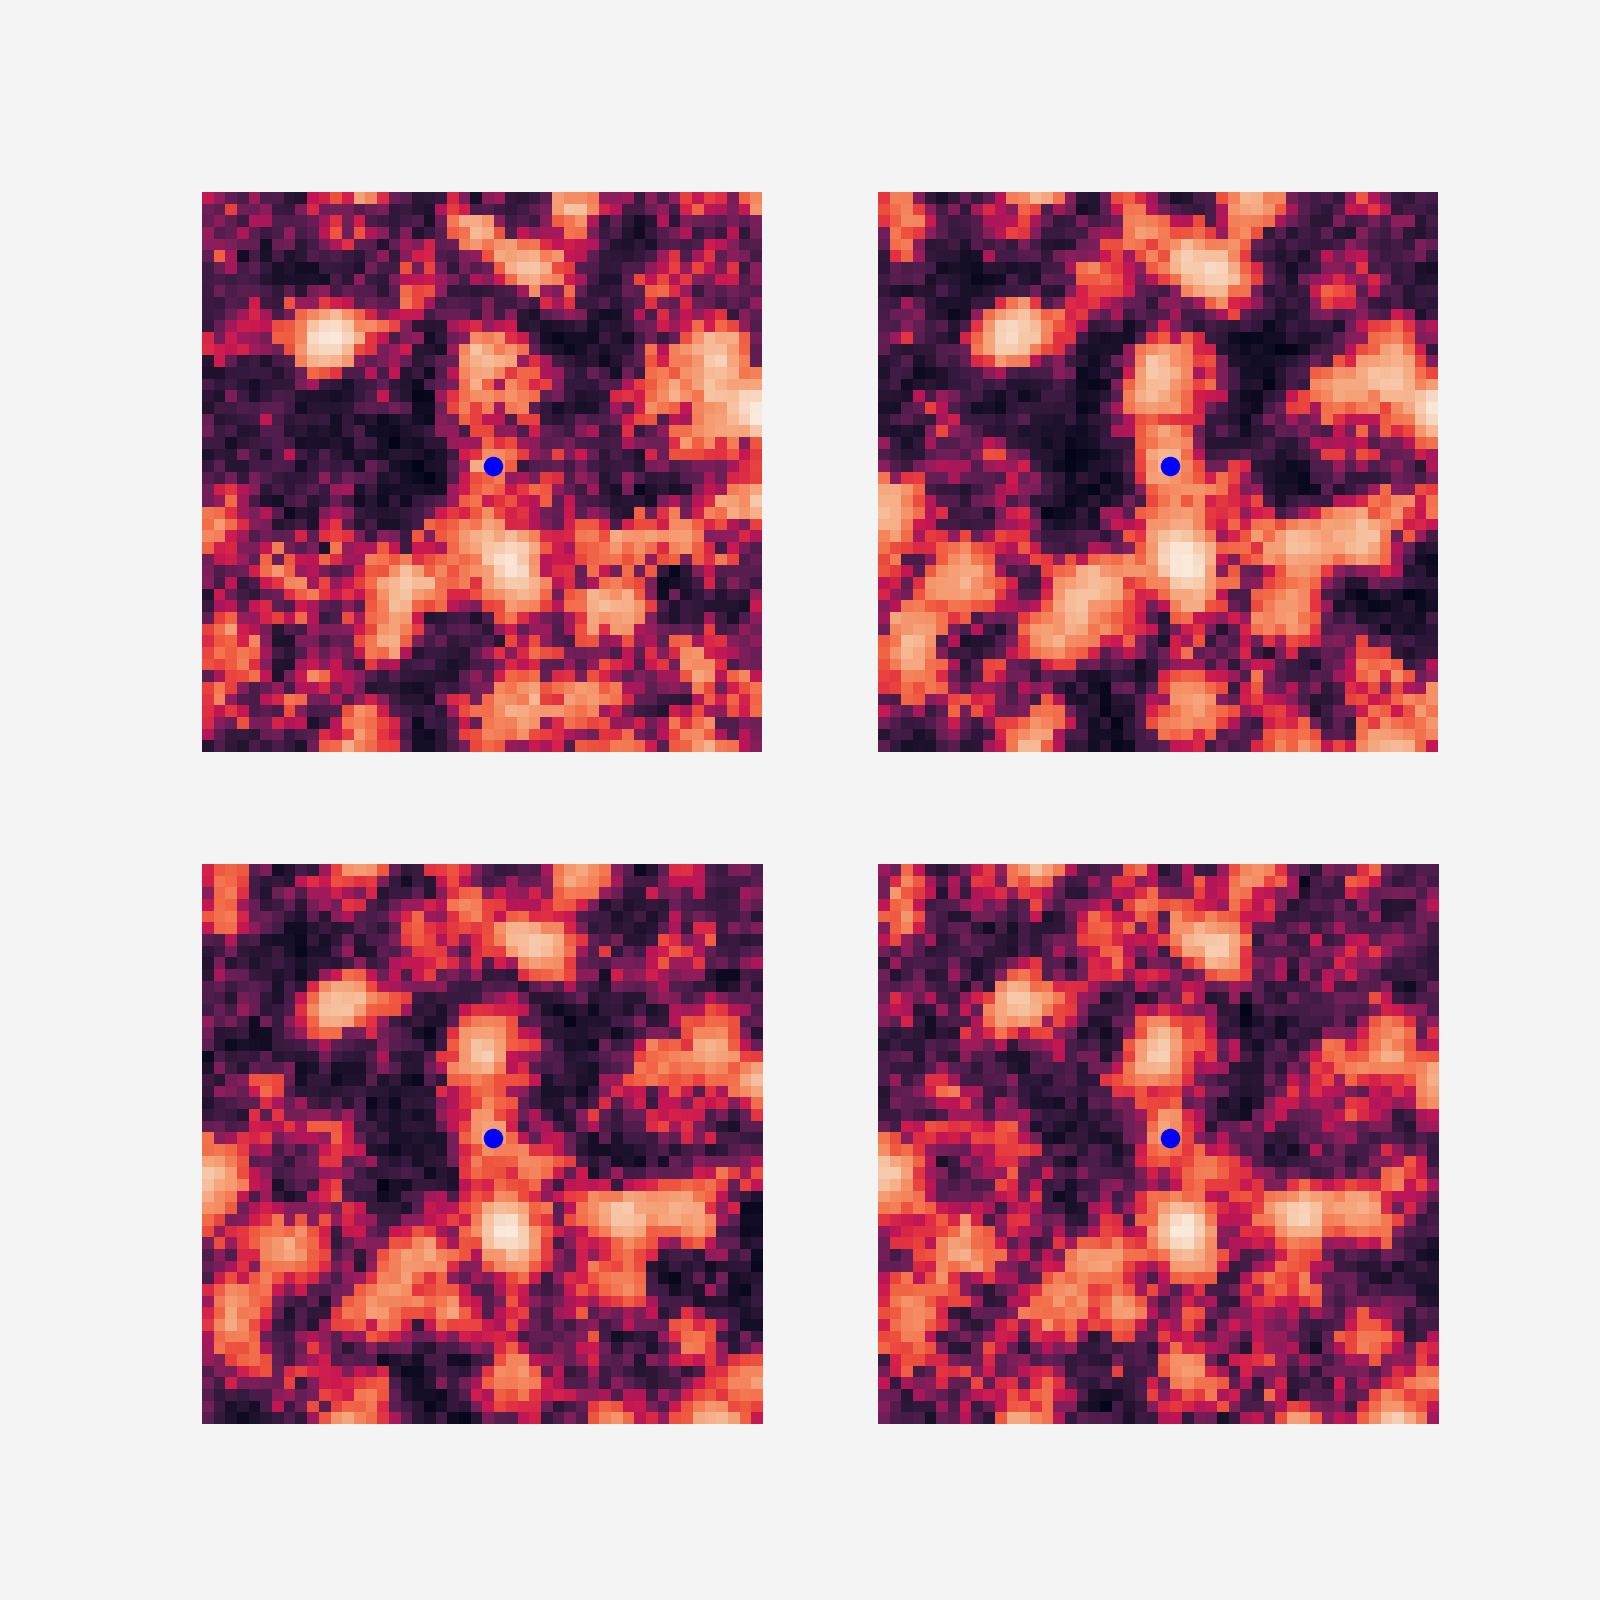

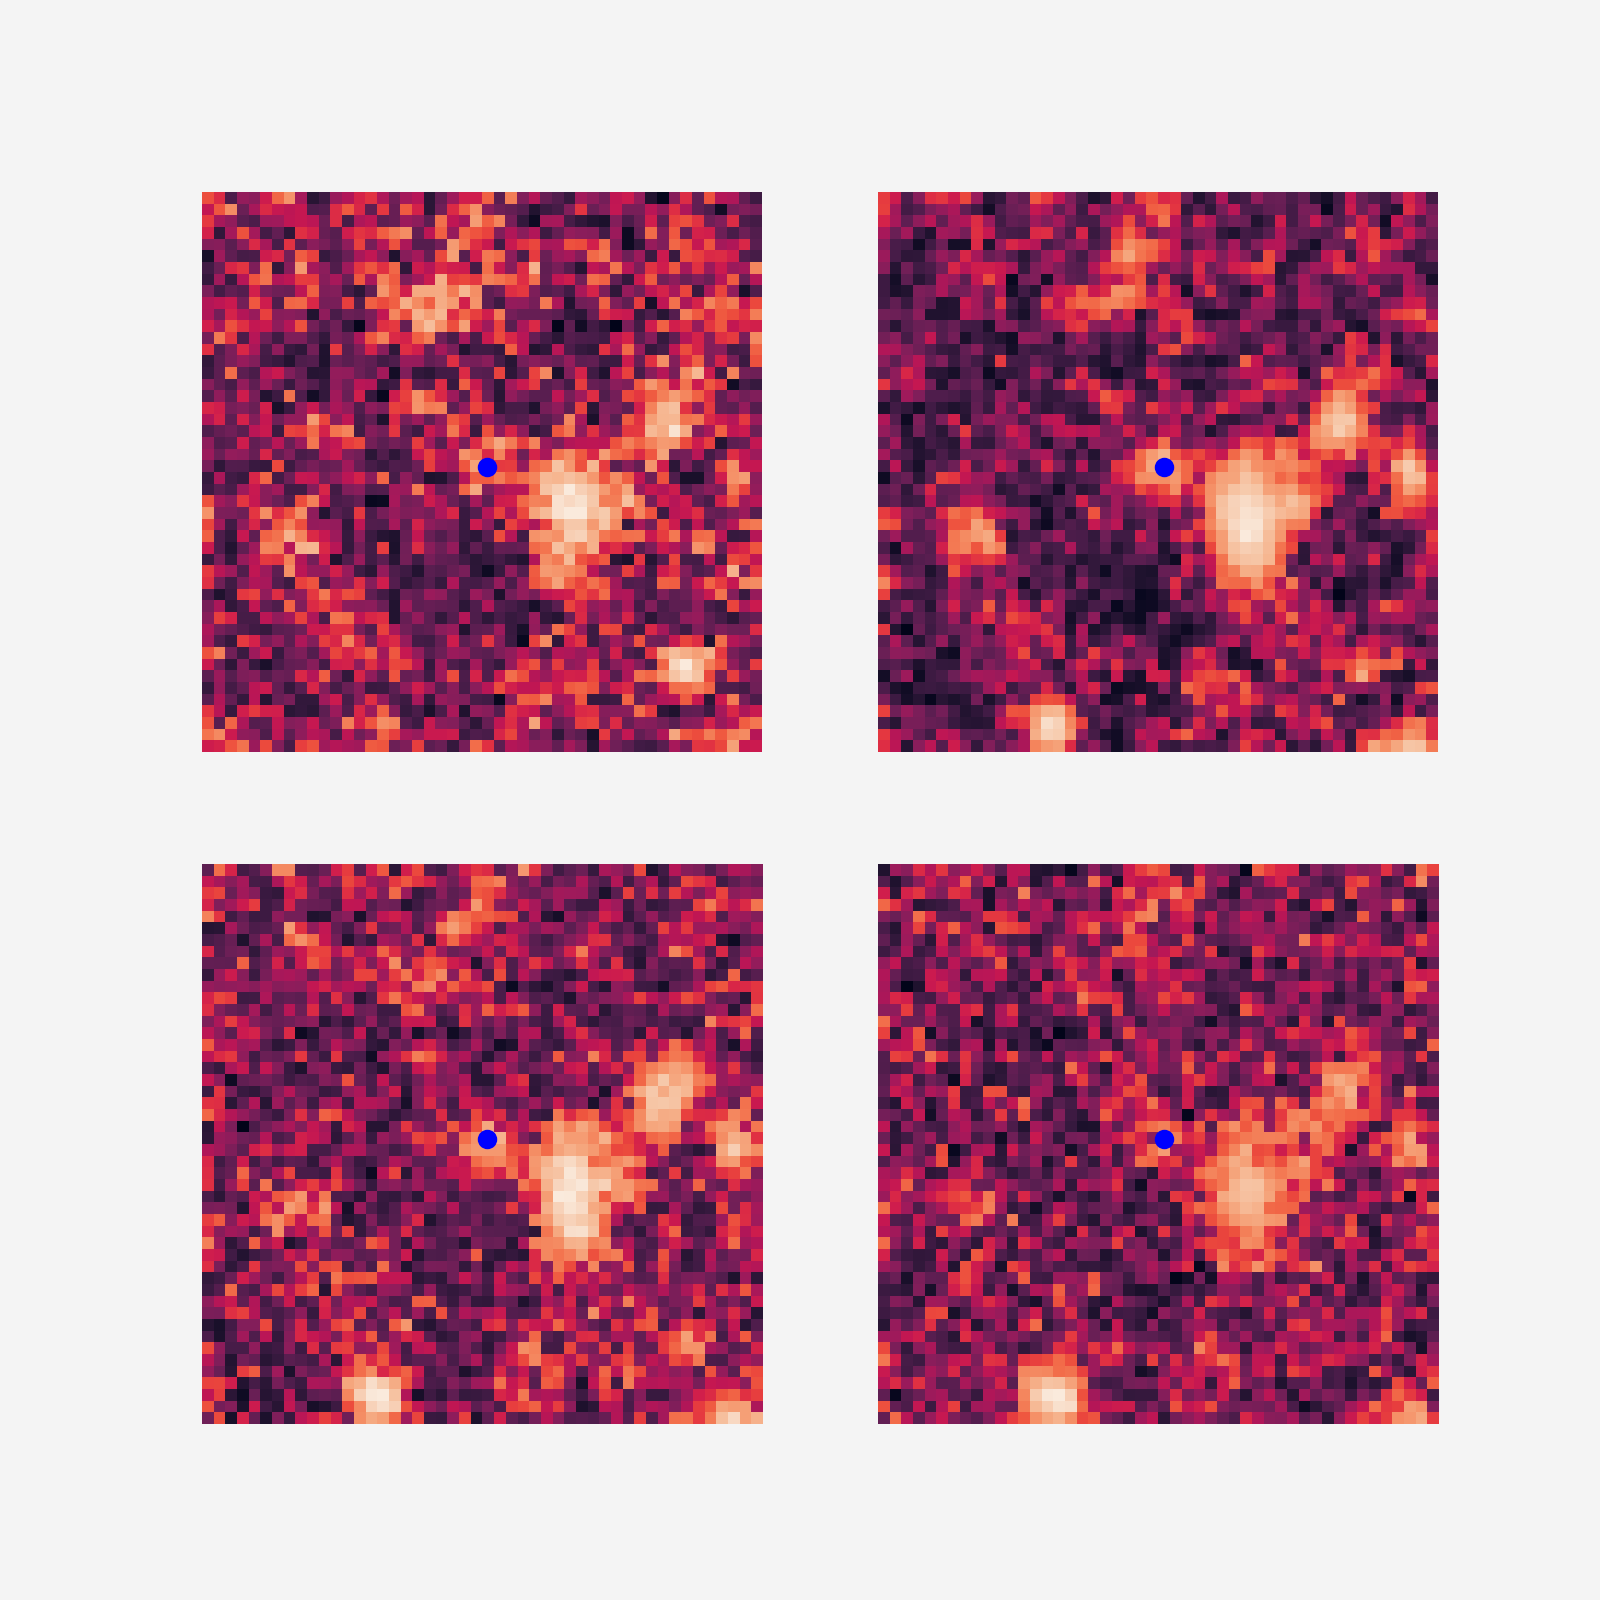

In [226]:
for i in range(msk.sum()):
    slice_id = pvals[i][0]
    slice_x = pvals[i][1]
    slice_y = pvals[i][2]

    box_size = 48

    mbobs = mbmeds.get_mbobs(slice_id)

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    for bind, ax in enumerate(axs.ravel()):
        im = mbobs[bind][0].image
        wgt = mbobs[bind][0].weight

        ax.imshow(
            np.arcsinh(im * np.sqrt(wgt))[
                int(slice_y + 0.5 - box_size/2):int(slice_y + 0.5 + box_size/2), 
                int(slice_x + 0.5 - box_size/2):int(slice_x + 0.5 + box_size/2)
            ],  
            cmap="rocket",
            origin="lower"

        )
        ax.grid(False)
        ax.axis("off")
        ax.plot(
            slice_x - int(slice_x + 0.5 - box_size/2), 
            slice_y - int(slice_y + 0.5 - box_size/2), 
            "ob",
        )

    for name in d.dtype.names:
        print("%s: %r" % (name, d[msk][i][name]))
    print("sb: %r" % sb[msk][i])
    print(" ")

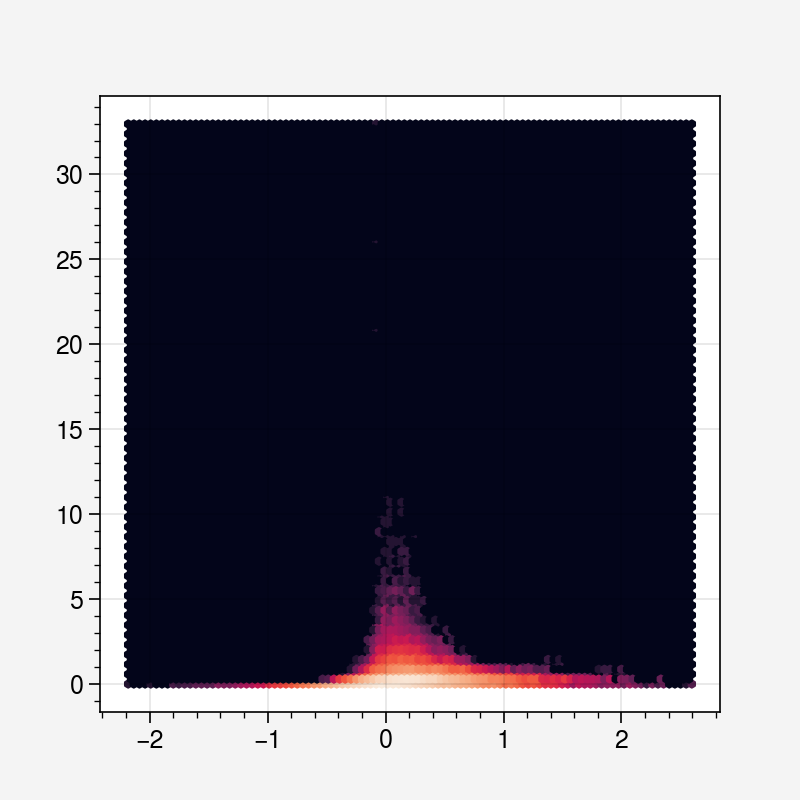

In [150]:
plt.hexbin(
    np.log10(g2_s2n), g2, bins="log", cmap="rocket",
)

In [95]:
ei = fitsio.read("./data/DES0000+0418_r5932p01_g_pizza-cutter-slices.fits.fz", ext="epochs_info")

In [100]:
ii = fitsio.read("./data/DES0000+0418_r5932p01_g_pizza-cutter-slices.fits.fz", ext="image_info")

In [102]:
msk = ei["id"] == slice_ids[0]

In [105]:
ei[msk]["image_id"]

array([1])

In [107]:
ii[1]

('red/D00372104_g_c01_r3539p01_immasked.fits.fz', 'sci', 'red/D00372104_g_c01_r3539p01_immasked.fits.fz', 'wgt', '', '', 'red/D00372104_g_c01_r3539p01_immasked.fits.fz', 'msk', 'bkg/D00372104_g_c01_r3539p01_bkg.fits.fz', 'sci', 1, 0, 31.496239, 0.25206035, 1., '{"airmass": 1.31, "ampseca": "[2048:1025,4096:1]", "ampsecb": "[1:1024,4096:1]", "aos": true, "attnum": 1, "az": 323.2872, "band": "g", "bcam": false, "bfcfil": "D_n20170406_r2959p01_bf.fits", "biasfil": "D_n20141020t1030_c01_r1471p01_biascor.fits", "bitpix": 8, "bpmfil": "D_n20141020t1030_c01_r1474p02_bpm.fits", "bunit": "electrons", "camshut": "Open", "camsym": "D", "ccdbin1": 1, "ccdbin2": 1, "ccdnum": 1, "ccdsec": "[1:2048,1:4096]", "ccdseca": "[1025:2048,1:4096]", "ccdsecb": "[1:1024,1:4096]", "cd1_1": -1.379667039033e-07, "cd1_2": 7.311890565455e-05, "cd2_1": -7.289678818534e-05, "cd2_2": -1.540471409943e-08, "checksum": "9G6PAF3N3F3N9F3N", "comment": "  and Astrophysics\', volume 376, page 359; bibcode: 2001A&A...376..359